# System analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
plt.gray()

In [2]:
debug=False

### 1) Load data from BIN files

In [3]:
wes_title='wes2015'
aida_title='aida'
rss_title='rss500'
reuters_title='reuters128'
titles=[aida_title, reuters_title, rss_title]#, wes_title]
systems=['agdistis', 'spotlight', 'wat']

In [4]:
### Load data from disk
import pickle
system_data_articles={}
for system in systems:
    system_data_articles[system]={}
    for data_title in titles:
        with open('%s_%s.bin' % (data_title, system), 'rb') as outfile:
            system_data_articles[system][data_title]=pickle.load(outfile)

#### DEBUG: Store agdistis output to a file

In [5]:
if debug:
    with open('agdmag_aida_debug.tsv', 'w') as w:
        w.write('collection\tarticle_ID\tbegin_index\tend_index\tmention\tgold_link\tsystem_link\n')
        for article in aida_agd_articles:
            for mention in article.entity_mentions:
                if mention.sys_link.startswith('http://aksw.org/'):
                    mention.sys_link = '--NME--'

                a_row=[article.collection, str(article.identifier), 
                       str(mention.begin_index), str(mention.end_index), 
                       mention.mention, mention.gold_link, 
                       mention.sys_link]
                w.write('\t'.join(a_row) + '\n')

In [6]:
import utils
import plot_utils
from collections import defaultdict

**1.1. Pick dataset**

In [7]:
system_articles = {}#'agdistis': agd_articles, 'spotlight': spot_articles, 'wat': wat_articles}

for system in systems:
    system_articles[system]=set()
    for data_title in titles: 
        system_articles[system] |= system_data_articles[system][data_title]

In [8]:
for article in system_articles['agdistis']:
    for mention in article.entity_mentions:
        if mention.sys_link.startswith('http://aksw.org/'):
            mention.sys_link = '--NME--'


### 2) Performance

<span style="background-color:lightgreen">Section 6.1. of the paper</span>

#### 2.1. Overall

In [9]:
scores=[]

In [10]:
skip_nils=True
skip_nonnils=False

for system in systems:
    print(system.upper())
    sys_acc=plot_utils.overall_performance_prf(system_articles[system], skip_nils, skip_nonnils)
    scores.append(['overall', system, sys_acc])
    print(sys_acc)
    print()


AGDISTIS
16959 9015 12032
0.6529221529221529 0.5849746473043358 0.6170835986536887
0.6170835986536887

SPOTLIGHT
21150 5505 7841
0.7934721440630276 0.7295367527853471 0.7601624555224096
0.7601624555224096

WAT
19027 2420 9964
0.8871637058796102 0.6563071297989032 0.7544708354811849
0.7544708354811849



#### 2.2. Prepare forms subset to evaluate ambiguous forms

In [11]:
def compute_acc_on_selection(arts, forms_set):
    correct=0
    total=0
    for article in arts:
        for entity in article.entity_mentions:
            if entity.mention in forms_set:
                total+=1
                if entity.gold_link==entity.sys_link:
                    correct+=1
    print(correct, total)
    return correct/total

In [12]:
def compute_prf_on_selection(arts, forms_set):
    tp=0
    fn=0
    fp=0
    for article in arts:
        for entity in article.entity_mentions:
            if entity.mention in forms_set:
                if entity.gold_link==entity.sys_link:
                    tp+=1
                else:
                    if entity.sys_link!='--NME--':
                        fp+=1
                    if entity.gold_link!='--NME--':
                        fn+=1
    print(tp, fp, fn)
    p=tp/(tp+fp)
    r=tp/(tp+fn)
    f1=2*p*r/(p+r)
    print(p,r,f1)
    return f1

#### 2.3. Only forms that are interpretted as NILs and not-NILs

In [13]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=False)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    nil_nonnil_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            if '--NME--' in interpretations[form]:
                nil_nonnil_forms.add(form)

    nn_f_acc=compute_prf_on_selection(system_articles[system], nil_nonnil_forms)
    print(system, nn_f_acc)
    scores.append(['forms with nils & non-nils', system, nn_f_acc])

1258 1401 1125
0.4731101918014291 0.5279060008392782 0.4990083300277668
agdistis 0.4990083300277668
1473 1389 847
0.5146750524109015 0.6349137931034483 0.5685063681976071
spotlight 0.5685063681976071
1739 929 718
0.6517991004497751 0.7077737077737077 0.6786341463414635
wat 0.6786341463414635


#### 2.4. Only ambiguous forms

In [14]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=True)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    ambiguous_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            ambiguous_forms.add(form)

    amb_f_acc=compute_prf_on_selection(system_articles[system], ambiguous_forms)
    print(system, amb_f_acc)
    scores.append(['ambiguous forms', system, amb_f_acc])

4324 4843 5707
0.47169193847496454 0.43106370252218124 0.4504635899572872
agdistis 0.4504635899572872
6502 3446 3498
0.6535987133092079 0.6502 0.6518949268097053
spotlight 0.6518949268097053
6108 1665 3922
0.785796989579313 0.6089730807577268 0.6861764871089142
wat 0.6861764871089142


In [15]:
scores

[['overall', 'agdistis', 0.6170835986536887],
 ['overall', 'spotlight', 0.7601624555224096],
 ['overall', 'wat', 0.7544708354811849],
 ['forms with nils & non-nils', 'agdistis', 0.4990083300277668],
 ['forms with nils & non-nils', 'spotlight', 0.5685063681976071],
 ['forms with nils & non-nils', 'wat', 0.6786341463414635],
 ['ambiguous forms', 'agdistis', 0.4504635899572872],
 ['ambiguous forms', 'spotlight', 0.6518949268097053],
 ['ambiguous forms', 'wat', 0.6861764871089142]]

['overall', 'ambiguous forms', 'forms with nils & non-nils']
['agdistis' 'spotlight' 'wat']
width: 0.2333333333333333
evaluation: overall
0.6170835986536887
0.7601624555224096
0.7544708354811849
evaluation: ambiguous forms
0.4504635899572872
0.6518949268097053
0.6861764871089142
evaluation: forms with nils & non-nils
0.4990083300277668
0.5685063681976071
0.6786341463414635


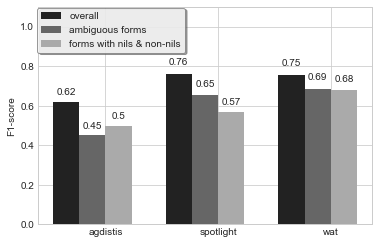

In [16]:
plot_utils.plot_scores(scores, title='Scores of systems')
#plot_scores(scores, title='Scores of systems')

### 3) Correlation between FORM frequency and accuracy

<span style="background-color:lightgreen">Section 6.2. of the paper</span>

In [17]:
from scipy.stats import pearsonr, spearmanr

In [18]:
acc_by_form = {system: defaultdict(float) for system in systems}
for system in systems:
    acc_by_form[system], forms_by_count = plot_utils.compute_accuracy_by_form(
        system_articles[system], skip_nils)

In [19]:
import math

def counts_to_log_counts(forms_by_count):
    forms_by_log_count={}
    for count, forms in forms_by_count.items():
        try:
            log_count=math.log(count)
        except:
            print(count)
        forms_by_log_count[log_count] = forms
    return forms_by_log_count

forms_by_log_count=counts_to_log_counts(forms_by_count)

In [65]:
def get_freq_intervals(forms_by_count):
    freqs_per_bucket=defaultdict(set)
    for count, forms in forms_by_count.items():
        try:
            log_count=math.log(count)
            rounded_log_count=round(log_count)
            freqs_per_bucket[rounded_log_count].add(count)
        except:
            print(count)
            
    interval_per_bucket = {}
    for freq, counts in freqs_per_bucket.items():
        mn = min(counts)
        mx = max(counts)
        interval_per_bucket[freq] = (mn,mx)
    return interval_per_bucket

freq_intervals = get_freq_intervals(forms_by_count)

In [20]:
def lmplot(dist1, dist2):
    data={
        'form frequency': dist1,
        'accuracy': dist2
    }
    df=pd.DataFrame(data)
    ax = sns.lmplot(data=df, x='form frequency', y='accuracy', lowess=True)


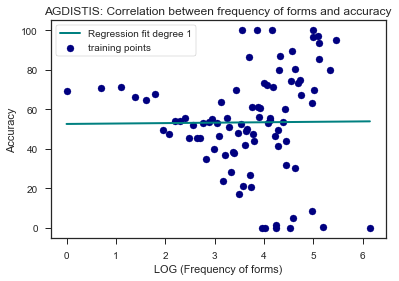

The Spearman correlation between X and Y is: 0.16691364250092894 . Significance:  0.11585791165501631


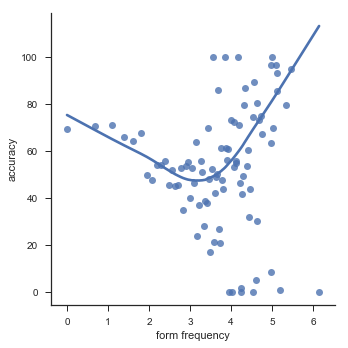

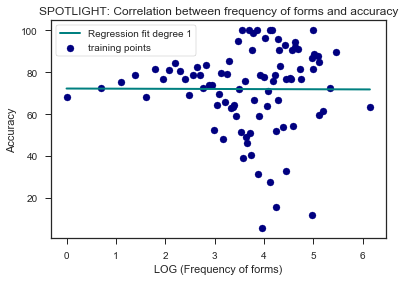

The Spearman correlation between X and Y is: 0.11393994396555106 . Significance:  0.28493165103467916


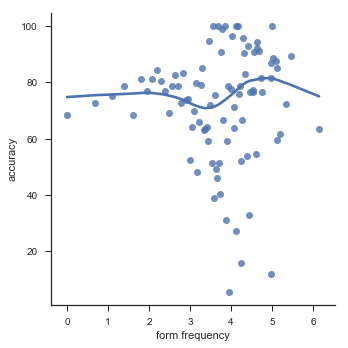

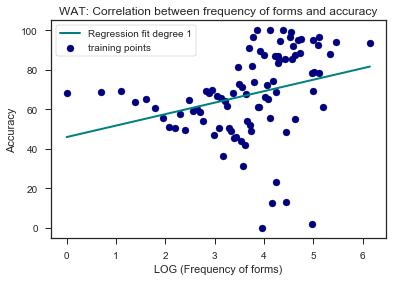

The Spearman correlation between X and Y is: 0.4724384171559932 . Significance:  2.5842179213890493e-06


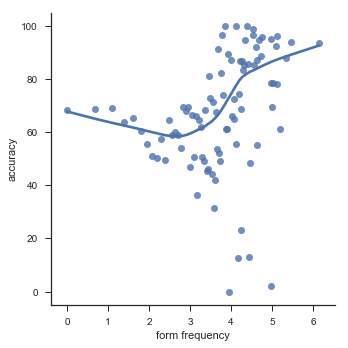

In [21]:
from collections import OrderedDict
import numpy as np
from scipy.stats import kendalltau
import pandas as pd
sns.set(style="ticks")

acc_by_freq={system: OrderedDict() for system in systems}

for system in systems:
        
    for count in sorted(forms_by_log_count.keys()):
        count_forms=forms_by_log_count[count]
        s=0
        for form in count_forms:
            s+=acc_by_form[system][form]
        acc_by_freq[system][count]=s/len(count_forms)
        
        
    dist1=np.array(list(acc_by_freq[system].keys()))
    dist2=np.array(list(acc_by_freq[system].values()))
    plot_utils.scatter_plot(dist1, dist2, 
                            title='%s: Correlation between frequency of forms and accuracy' % system.upper(),
                            x_axis='LOG (Frequency of forms)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

#    fig = plt.figure()
#    sns.jointplot(dist1, dist2, kind="hex", stat_func=kendalltau, color="#4CB391")
#    fig.savefig('img/%s-ff-acc.png' % system)
    lmplot(dist1,dist2)
    
    
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 4) Entropy

In [22]:
from scipy.stats import entropy
form_entropies={}
for form in ambiguous_forms:
    counts=plot_utils.get_form_counts(system_articles['spotlight'], form)
    counts=list(counts)
    form_entropies[form]=entropy(counts ,base=len(counts))

In [23]:
def multi_plot_line_with_whiskers(x, y, xl='', yl='', a=None, xlim=None, save=False, system=''):

    amb_data = {xl: x,
                yl: y}

    df = pd.DataFrame(amb_data)

    ax = sns.pointplot(x=xl, y=yl, data=df, ax=a)
    ax.set_title(system.upper())

    if xlim:
            ax.set(xlim=(xlim[0], xlim[1]))
    ax.set(ylim=(0, None))



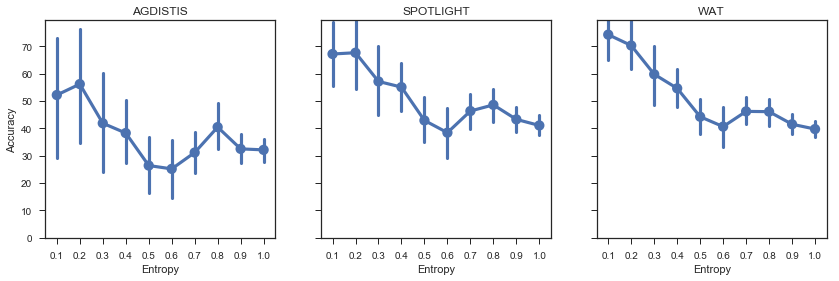

In [24]:
xs=[]
ys=[]

fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(14,4))
cnt=0
for system in systems:
    for form, entropy in form_entropies.items():
        xs.append(round(entropy,1))
        ys.append(acc_by_form[system][form])
       
    if cnt==0:
        yl='Accuracy'
    else:
        yl=''
    multi_plot_line_with_whiskers(xs, ys,
                        xl='Entropy',
                        yl=yl, a=axs[cnt], system=system)
    cnt+=1
    
plt.show()

save=True
if save:
    fig.savefig('img/entropy_accuracy.png')

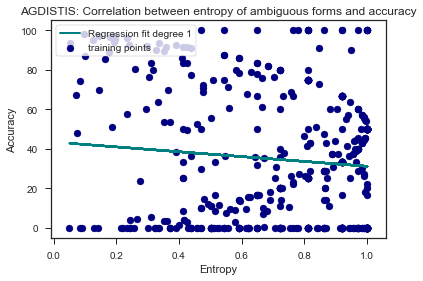

The Spearman correlation between X and Y is: -0.04951040643506969 . Significance:  0.2653469220866594


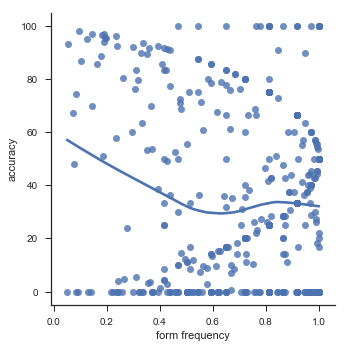

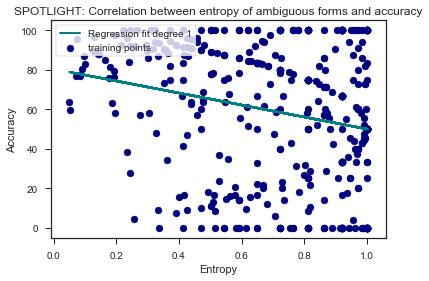

The Spearman correlation between X and Y is: -0.23040307108154878 . Significance:  1.512428595533182e-07


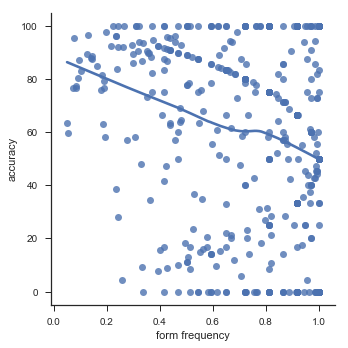

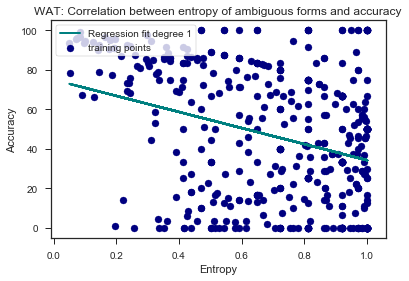

The Spearman correlation between X and Y is: -0.2889134558480473 . Significance:  3.1838082833690196e-11


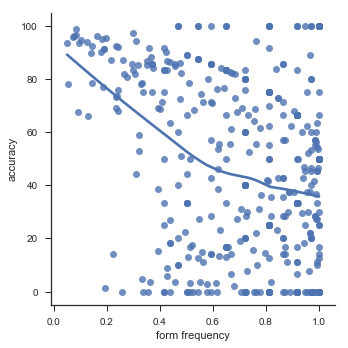

In [25]:
for system in systems:
    dist1=[]
    dist2=[]
    for f in ambiguous_forms:
        dist1.append(form_entropies[f])
        dist2.append(acc_by_form[system][f])

    dist1=np.array(dist1)
    dist2=np.array(dist2)
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between entropy of ambiguous forms and accuracy' % system.upper(),
                            x_axis='Entropy',
                            y_axis='Accuracy',
                            save=True
                            )

    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
    
    #fig = plt.figure()
    #sns.jointplot(dist1, dist2, kind="hex", stat_func=kendalltau, color="#4CB391")
    #
    #fig.savefig('img/%s-ff-acc.png' % system)
    
    lmplot(dist1, dist2)

### 5) Correlation between instance frequency and accuracy

<span style="background-color:lightgreen">Section 6.3. of the paper</span>

In [26]:
acc_by_uri = {system: defaultdict(float) for system in systems}
for system in systems:
    acc_by_uri[system], uris_by_count = plot_utils.compute_accuracy_by_uri(
        system_articles[system], skip_nils)

In [27]:
uris_by_log_count=counts_to_log_counts(uris_by_count)

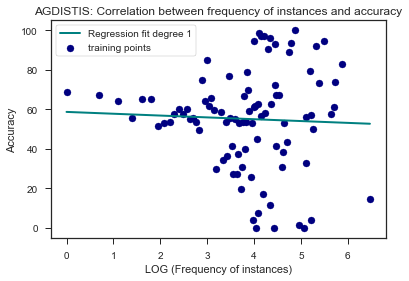

The Spearman correlation between X and Y is: 0.04918630904803034 . Significance:  0.6377953750320826


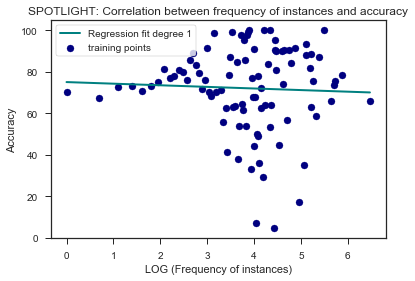

The Spearman correlation between X and Y is: 0.014637670698085024 . Significance:  0.8886393547420061


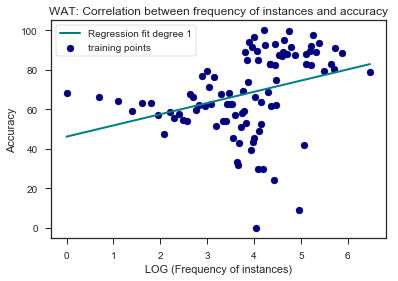

The Spearman correlation between X and Y is: 0.4679478380233356 . Significance:  1.9773193786232527e-06


In [28]:
acc_by_freq_uris={system: OrderedDict() for system in systems}

for system in systems:
        
    for count in sorted(uris_by_log_count.keys()):
        count_uris=uris_by_log_count[count]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_freq_uris[system][count]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_freq_uris[system].keys()))
    dist2=np.array(list(acc_by_freq_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between frequency of instances and accuracy' % system.upper(),
                            x_axis='LOG (Frequency of instances)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 6) Correlation between instance PageRank and accuracy

In [29]:
skip_zeros=True

In [30]:
uris_by_pr = defaultdict(set)
uri_pr={}
for article in system_articles['spotlight']:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            pagerank=int(entity.gold_pr)
            if skip_zeros and pagerank==0: continue
            uris_by_pr[pagerank].add(entity.gold_link)
            uri_pr[entity.gold_link]=entity.gold_pr

In [31]:
uris_by_log_pr=counts_to_log_counts(uris_by_pr)

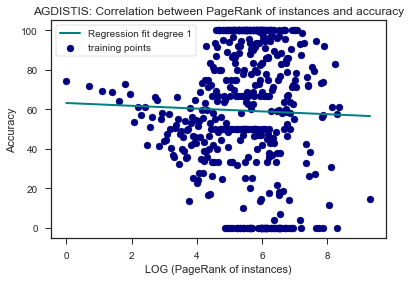

The Spearman correlation between X and Y is: 0.0035549487652399565 . Significance:  0.9369905218164837


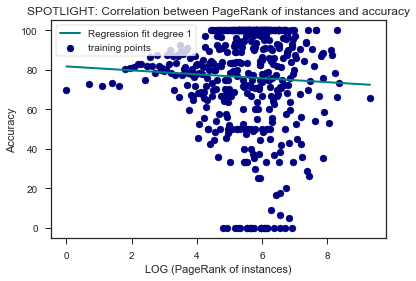

The Spearman correlation between X and Y is: 0.036331461820497485 . Significance:  0.4189854161728589


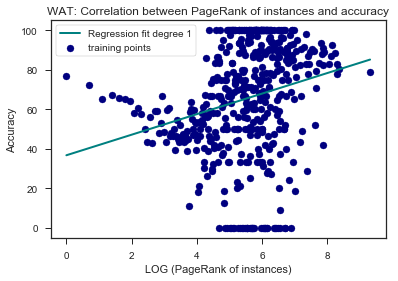

The Spearman correlation between X and Y is: 0.29534676537276233 . Significance:  1.8401276698079325e-11


In [32]:
acc_by_pr_uris={system: OrderedDict() for system in systems}

for system in systems:
        
    for pr in sorted(uris_by_log_pr.keys()):


        count_uris=uris_by_log_pr[pr]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_pr_uris[system][pr]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_pr_uris[system].keys()))
    dist2=np.array(list(acc_by_pr_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between PageRank of instances and accuracy' % system.upper(),
                            x_axis='LOG (PageRank of instances)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 7) Correlation between instance ranks (of a form) and accuracy

<span style="background-color:lightgreen">Section 6.4. of the paper</span>


**7.1. Collect interpretations for a form**


In [33]:
interpretations=defaultdict(set)
for article in system_articles['spotlight']:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [34]:
interpretations['Marseille']

{'Marseille', 'Olympique_de_Marseille'}

**7.2. Aggregate per rank**

In [35]:
def get_freq_totals(articles, skip_nils=True, ambiguous_only=True):
    total_per_form=defaultdict(dict)
    for article in articles:
        for mention in article.entity_mentions:
                form=mention.mention
                meaning=mention.gold_link
                if skip_nils and meaning=='--NME--':
                    continue

                if ambiguous_only and form not in ambiguous_forms:
                    continue
                if meaning not in total_per_form[form]:
                    total_per_form[form][meaning]=0
                total_per_form[form][meaning]+=1
    return total_per_form

def get_pr_totals(articles, skip_nils, ambiguous_only):
    total_per_form=get_freq_totals(articles, skip_nils, ambiguous_only)
    form_pageranks=defaultdict(dict)
    for form, meanings in total_per_form.items():
        if ambiguous_only and form not in ambiguous_forms:
            continue
        #for uri, total in meanings.items():
            #acc_per_form_meaning[system][form][uri]=correct_per_form[form][uri]/total
        for uri in meanings.keys():
            if uri in uri_pr:
                form_pageranks[form][uri]= uri_pr[uri]
    return form_pageranks


In [36]:
# Prepare the ranks first

def prepare_ranks(articles, min_frequency=0, ambiguous_only=True, skip_nils=True, factor='freq'):
    rank_tuples=defaultdict(set)
    if factor == 'freq':
        total_per_form=get_freq_totals(articles, skip_nils, ambiguous_only)
    else: # pagerank
        total_per_form=get_pr_totals(articles, skip_nils, ambiguous_only)
    
    for form, data in total_per_form.items():
        if sum(data.values())<=min_frequency:
            continue
        sorted_by_rank=sorted(data.items(), key=lambda x:x[1], reverse=True)
        rank=1
        for ranked_URI, freq in sorted_by_rank:
            t=(form, ranked_URI)
            rank_tuples[rank].add(t)
            rank+=1

    return rank_tuples

In [37]:
def evaluate_ranks(articles, rank_tuples):
    rank_tp=defaultdict(int)
    rank_fn=defaultdict(int)
    rank_fp=defaultdict(int)
    
    for article in articles:
        for mention in article.entity_mentions:
                form=mention.mention
                meaning=mention.gold_link
                sys_meaning=mention.sys_link
                t_gold=(form, meaning)
                t_sys=(form, sys_meaning)
                for rank, r_tuples in rank_tuples.items():
                    if t_gold in r_tuples and t_sys in r_tuples:
                        rank_tp[rank]+=1
                        break
                    elif t_gold in r_tuples:
                        rank_fn[rank]+=1
                    elif t_sys in r_tuples:
                        rank_fp[rank]+=1
    print('tp', rank_tp)
    print('fp', rank_fp)
    print('fn', rank_fn)
    
    rank_prec={}
    rank_recall={}
    rank_f1={}
    
    for rank in range(1,13):
        if rank_tp[rank]+rank_fp[rank]>0:
            rank_prec[rank]=rank_tp[rank]/(rank_tp[rank]+rank_fp[rank])
        else:
            rank_prec[rank]=0.0
        if rank_tp[rank]+rank_fn[rank]>0:
            rank_recall[rank]=rank_tp[rank]/(rank_tp[rank]+rank_fn[rank])
        else:
            rank_recall[rank]=0.0
        if rank_prec[rank]+rank_recall[rank]>0:
            rank_f1[rank]=2*rank_prec[rank]*rank_recall[rank]/(rank_prec[rank]+rank_recall[rank])
        else:
            rank_f1[rank]=0.0
    print('precision', rank_prec)
    print()
    print('recall', rank_recall)
    print()
    print('f1', rank_f1)
    print()
    return rank_prec, rank_recall, rank_f1

In [38]:
def plot_prf(data, systems, a, maxrank=12, title=''):
    a_list=[]
    for rank in range(1,maxrank+1):
        s=0
        for system in systems:
            s+=data[system][rank]
        a_list.append(s/len(systems))
    print(np.arange(1,maxrank+1))
    a.plot(np.arange(1,maxrank+1), a_list, 'b-o')
    a.set_xlabel("Rank")
    a.set_title(title)

In [39]:
def rank_analysis(systems, system_articles, ambiguous_only=True, factor='freq'):

    print(factor)
    fig, axs = plt.subplots(1,3, sharey=True, figsize=(14,3))
    p={}
    r={}
    f1={}

    for system in systems:
        rank_tuples=prepare_ranks(system_articles[system], 
                                  ambiguous_only=ambiguous_only, 
                                  factor=factor)
        #print(rank_tuples)
        p[system], r[system], f1[system] = evaluate_ranks(system_articles[system], 
                                                          rank_tuples)

        print()

    plot_prf(p, systems, axs[0], title="PRECISION")
    plot_prf(r, systems, axs[1], title="RECALL")
    plot_prf(f1, systems, axs[2], title="F1-SCORE")

    plt.show()

    fig.savefig('img/accuracy_per_%s_rank.png' % factor, bbox_inches='tight')

freq
tp defaultdict(<class 'int'>, {2: 420, 3: 37, 1: 3820, 4: 7, 5: 2, 6: 1})
fp defaultdict(<class 'int'>, {2: 1000, 3: 400, 6: 170, 1: 614, 5: 68, 4: 60})
fn defaultdict(<class 'int'>, {1: 4272, 2: 1077, 3: 249, 4: 71, 8: 2, 9: 2, 5: 19, 6: 8, 7: 3, 10: 2, 11: 1, 12: 1})
precision {1: 0.8615245827695084, 2: 0.29577464788732394, 3: 0.08466819221967964, 4: 0.1044776119402985, 5: 0.02857142857142857, 6: 0.005847953216374269, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

recall {1: 0.472071181413742, 2: 0.280561122244489, 3: 0.12937062937062938, 4: 0.08974358974358974, 5: 0.09523809523809523, 6: 0.1111111111111111, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

f1 {1: 0.6099313428069616, 2: 0.2879670894754885, 3: 0.10235131396957124, 4: 0.09655172413793105, 5: 0.04395604395604396, 6: 0.011111111111111112, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}


tp defaultdict(<class 'int'>, {1: 5528, 2: 796, 4: 29, 3: 132, 6: 2, 5: 7, 10: 2})
fp defaultdict(<class 'int'>, {1: 420

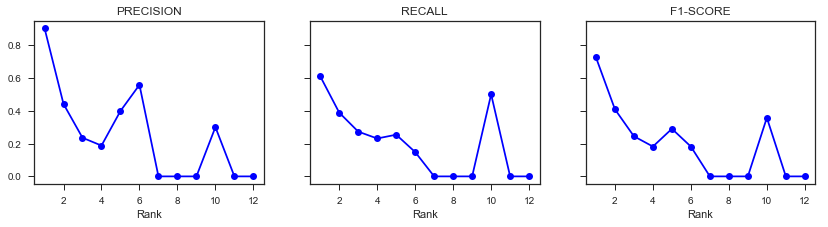

In [40]:
rank_analysis(systems, system_articles, ambiguous_only=True, factor='freq')

#### 7.3 PR ranks


pr
tp defaultdict(<class 'int'>, {1: 3945, 2: 293, 3: 17, 4: 18})
fp defaultdict(<class 'int'>, {1: 1757, 2: 374, 3: 178, 4: 3})
fn defaultdict(<class 'int'>, {1: 2856, 3: 517, 2: 2040, 5: 102, 4: 99, 6: 17, 7: 2, 11: 5, 10: 5, 9: 3, 12: 1, 8: 1})
precision {1: 0.6918625043844265, 2: 0.43928035982008995, 3: 0.08717948717948718, 4: 0.8571428571428571, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

recall {1: 0.580061755624173, 2: 0.12558936990998715, 3: 0.031835205992509365, 4: 0.15384615384615385, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}

f1 {1: 0.6310485483483964, 2: 0.19533333333333336, 3: 0.04663923182441702, 4: 0.2608695652173913, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0}


tp defaultdict(<class 'int'>, {1: 4902, 3: 159, 2: 1276, 5: 87, 4: 50, 6: 13, 11: 5, 7: 2})
fp defaultdict(<class 'int'>, {2: 621, 1: 534, 3: 215, 4: 213, 6: 80, 5: 97, 7: 3})
fn defaultdict(<class 'int'>, {1: 1899, 3: 375, 2: 1057, 8: 1, 4:

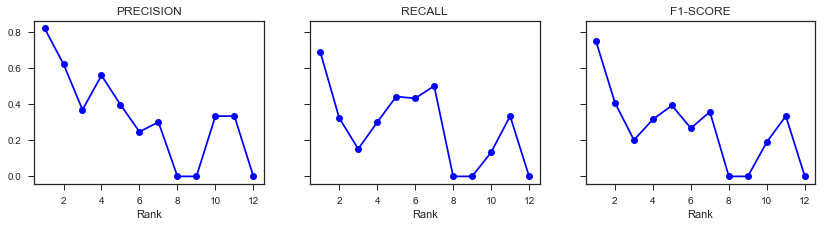

In [41]:
rank_analysis(systems, system_articles, ambiguous_only=True, factor='pr')

### 8) Ambiguity and frequency together against accuracy

In [42]:
def heatmap_me(AMB, FREQ, ACC, system, a, ylbl='', cbar=False):
    data = pd.DataFrame({'AMB': AMB, 'FREQ': FREQ, 'ACC': ACC})
    data_pivoted = data.pivot("FREQ", "AMB", "ACC")
#    fig=plt.figure(figsize = (12,7))
    ax = sns.heatmap(data_pivoted, annot=True, linewidths=.5, ax=a,cbar=cbar,fmt='g')
    ax.set_ylabel(ylbl)
    ax.set_title(system.upper())
    for _, spine in ax.spines.items():
        spine.set_edgecolor('darkblue')
        spine.set_visible(True)
#    plt.show()
#    fig.savefig('img/%s_amb_frequency_acc.png' % system)

In [43]:
def split_forms_per_amb_freq_pair(ambiguity, forms_by_log_count):
    af_pairs=defaultdict(set)
    for log_freq, forms in forms_by_log_count.items():
        for form in forms:
            amb=ambiguity[form]
            rounded_freq=round(log_freq)
            af_pairs[(amb, rounded_freq)].add(form)
    return af_pairs

In [57]:
def evaluate_af_pairs(af_pairs, articles, skip_nils=True):
    
    tp=defaultdict(int)
    fn=defaultdict(int)
    fp=defaultdict(int)
    
    counts=defaultdict(set)
    for article in articles:
        for mention in article.entity_mentions:
            gold = mention.gold_link
            syslink = mention.sys_link
            form = mention.mention
            if skip_nils and gold=='--NME--':
                continue
            this_pair=None
            for pair, forms in af_pairs.items():
                if form in forms:
                    this_pair=pair
            if not this_pair:
                continue
            else:
                counts[this_pair].add(form)
            if gold==syslink:
                tp[this_pair]+=1
            else:
                if syslink!='--NME--':
                    fp[this_pair]+=1
                fn[this_pair]+=1
    
    agg_counts={}
    for pair, forms in counts.items():
        agg_counts[pair]=len(forms)
    
    prec=defaultdict(float)
    recall=defaultdict(float)
    f1=defaultdict(int)
    
    for pair in af_pairs.keys():
        prec[pair]=tp[pair]/(tp[pair]+fp[pair])
        recall[pair]=tp[pair]/(tp[pair]+fn[pair])
        if prec[pair]+recall[pair]>0:
            f1[pair]=int(100.0*2*prec[pair]*recall[pair]/(prec[pair]+recall[pair]))
        else:
            f1[pair]=0
    
    return f1, agg_counts

In [58]:
total_per_form = get_freq_totals(system_articles[systems[0]], ambiguous_only=False)
af_pairs=split_forms_per_amb_freq_pair(ambiguity, forms_by_log_count)

In [68]:
def plot_heatmap(data, cnt, axs=None, system=''):
    AMB=[]
    FREQ=[]
    ACC=[]

    for this_pair, val in data.items():

        ACC.append(val)
        AMB.append(this_pair[0])
        mn=freq_intervals[this_pair[1]][0]
        mx=freq_intervals[this_pair[1]][1]
        FREQ.append(freq_intervals[this_pair[1]])
    if cnt>0:
        ylbl=''
    else:
        ylbl='FREQ'
    heatmap_me(AMB, FREQ, ACC, system, axs[cnt], cbar=(cnt==2), ylbl=ylbl)


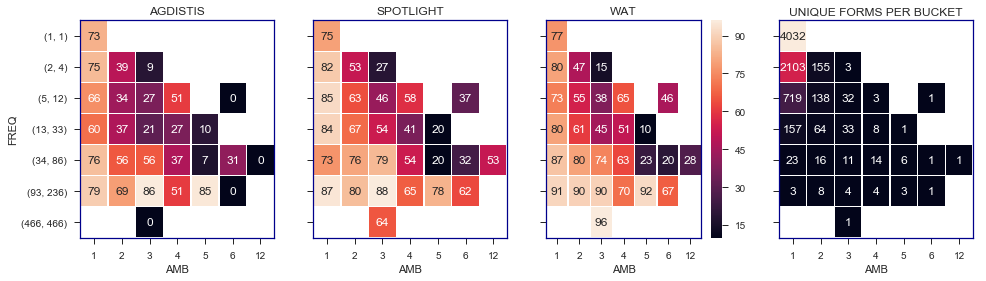

In [69]:
fig, axs = plt.subplots(ncols=4, sharey=True,figsize=(16,4))
cnt=0

for system in systems:
    
    f1s, counts = evaluate_af_pairs(af_pairs, system_articles[system])
    
    plot_heatmap(f1s, cnt, axs, system)

    cnt+=1
    
plot_heatmap(counts, cnt, axs, 'unique forms per bucket')
    
plt.show()
fig.savefig('img/amb_frequency_acc.png')

In [50]:
from copy import deepcopy

totals=total_per_form_all['agdistis']
freq_baseline_articles=deepcopy(system_articles['agdistis'])
pr_baseline_articles=deepcopy(system_articles['agdistis'])



NameError: name 'total_per_form_all' is not defined

In [ ]:
form_to_mostfreq=defaultdict(lambda: '--NME--')
form_to_highest_pr = defaultdict(lambda: '--NME--')
for form, dist in totals.items():
    key_max = max(dist.keys(), key=(lambda k: dist[k]))
    form_to_mostfreq[form]=key_max
#    print(form, dist, key_max)
#    input('continue')

In [ ]:
for article in freq_baseline_articles:
    for mention in article.entity_mentions:
        mention.sys_link=form_to_mostfreq[mention.mention]
        print(mention.sys_link)

In [ ]:
sys_acc=plot_utils.overall_performance_prf(freq_baseline_articles, skip_nils=True, skip_nonnils=False)
print(sys_acc)
scores.append(['overall', 'x freq baseline', sys_acc])


In [ ]:
amb_f_acc=compute_prf_on_selection(freq_baseline_articles, ambiguous_forms)
print(amb_f_acc)

nn_f_acc=compute_prf_on_selection(freq_baseline_articles, nil_nonnil_forms)
print(nn_f_acc)
scores.append(['ambiguous forms', 'x freq baseline', amb_f_acc])
scores.append(['forms with nils & non-nils', 'x freq baseline', nn_f_acc])

In [ ]:
plot_utils.plot_scores(scores, title='Scores of systems')


### 8) Notes

* very basic baseline - throw away dbpedia, randomly assign from the training data - build this baseline
* always try the most frequent one
* popular, transparent, and the best one - distinguish between open source systems
* look at coreference too (noun phrases and pronouns)
* annotation or not of coreferential expressions (we can also just use them in a solution)? 

**5.3. Aggregate per rank**



#### Summary of the todos:
* Another system or 2 (spotlight) - PIEK: take popular, transparent, and the best one
* More datasets
* NIL entities
* Baseline
* Coreference